In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from setGPU import setGPU
setGPU(3)

setGPU: Setting GPU to: 3


In [3]:
random_state=999

# Load data

In [4]:
from secml.data.loader import CDataLoaderMNIST
loader = CDataLoaderMNIST()
tr = loader.load('training')
ts = loader.load('testing')

# Normalize the data
tr.X /= 255
ts.X /= 255

/home/crecchi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
tr.X.shape, ts.X.shape

((60000, 784), (10000, 784))

Split data into train-validation set (Stacked Generalization alike)

In [6]:
from secml.data.splitter import CTrainTestSplit

In [7]:
tr, vl = CTrainTestSplit(test_size=0.5, random_state=random_state).split(tr)

In [8]:
tr.X.shape[0], vl.X.shape[0]

(30000, 30000)

# NN classifier

In [9]:
import torch
from torch import nn, optim

In [10]:
class Flatten(nn.Module):
    """Layer custom per reshape del tensore
    """
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

In [11]:
import torch
from torch import nn

class MNISTCNN(nn.Module):
    """Model with input size (-1, 28, 28) for MNIST 3-classes dataset."""
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.flat = Flatten()
        self.fc1 = nn.Linear(1024, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        # 1st block
        x = torch.relu(self.conv1(x))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        # 2nd block
        x = torch.relu(self.conv3(x))
        x = torch.relu(torch.max_pool2d(self.conv4(x), 2))
        # Flatten
        x = self.flat(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [12]:
# import numpy as np
# import torch.autograd as autograd

# def compute_out_size(in_size, mod):
#     """
#     Compute output size of Module `mod` given an input with size `in_size`.
#     """
    
#     f = mod.forward(autograd.Variable(torch.Tensor(1, *in_size)))
#     return int(np.prod(f.size()[1:]))

In [13]:
net = MNISTCNN()
# x = torch.Tensor(1, 28, 28) # shape = (batch size, channels, height, width)
# print(compute_out_size(x.size(), net))

In [14]:
!conda list | grep summary

torchsummary              1.5.1                    pypi_0    pypi


In [15]:
from torchsummary import summary

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 32, 24, 24]           9,248
            Conv2d-3           [-1, 64, 10, 10]          18,496
            Conv2d-4             [-1, 64, 8, 8]          36,928
           Flatten-5                 [-1, 1024]               0
            Linear-6                  [-1, 200]         205,000
            Linear-7                  [-1, 200]          40,200
            Linear-8                   [-1, 10]           2,010
Total params: 312,202
Trainable params: 312,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.40
Params size (MB): 1.19
Estimated Total Size (MB): 1.59
----------------------------------------------------------------


### Wrap it

In [17]:
from torch import optim

# Random seed
torch.manual_seed(0)

net = MNISTCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.01, momentum=0.9)

from secml.ml.classifiers import CClassifierPyTorch
dnn = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         epochs=25,
                         batch_size=128,
                         input_shape=(1, 28, 28),
                         random_state=0)

In [18]:
dnn.verbose = 1  # Can be used to display training process output

In [19]:
print("Training started...")
dnn.fit(tr.X, tr.Y)
print("Training completed!")

Training started...
2020-05-20 11:54:05,228 - CClassifierPyTorch.0x7f0e07d9a0b8 - INFO - [epoch: 1] loss: 4.242
2020-05-20 11:55:04,278 - CClassifierPyTorch.0x7f0e07d9a0b8 - INFO - [epoch: 11] loss: 0.033
2020-05-20 11:56:03,325 - CClassifierPyTorch.0x7f0e07d9a0b8 - INFO - [epoch: 21] loss: 0.004
Training completed!


In [20]:
dnn.verbose = 0

In [21]:
print(dnn)

CClassifierPyTorch{'classes': CArray(10,)(dense: [0 1 2 3 4 5 6 7 8 9]), 'n_features': 784, 'preprocess': None, 'n_jobs': 1, 'model': MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten()
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
), 'trained': True, 'input_shape': (1, 28, 28), 'softmax_outputs': False, 'batch_size': 128, 'loss': CrossEntropyLoss(), 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
), 'optimizer_scheduler': None, 'epochs': 25}


In [22]:
label_torch = dnn.predict(ts.X, return_decision_function=False)

from secml.ml.peval.metrics import CMetric
acc_torch = CMetric.create('accuracy').performance_score(ts.Y, label_torch)

print("Model Accuracy: {}".format(acc_torch))

Model Accuracy: 0.9885


---

# Generate Adversarial Samples

In [23]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:100, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=dnn,
                                    surrogate_classifier=dnn,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    attack_ds.X, attack_ds.Y, double_init=True)
print("Attack complete!")

Attack started...
Attack complete!


In [24]:
attack_ds.X.shape

(100, 784)

In [25]:
from secml.ml.peval.metrics import CMetric
metric = CMetric.create('accuracy')

acc = metric.performance_score(
    y_true=attack_ds.Y, y_pred=dnn.predict(attack_ds.X))
acc_attack = metric.performance_score(
    y_true=attack_ds.Y, y_pred=eva_y_pred)

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))

Accuracy on reduced test set before attack: 100.00%
Accuracy on reduced test set after attack: 7.00%


---

## Attack debug plots

In [26]:
dbg = loader.load('testing', digits=(1,8))
dbg.X /= 255.

In [27]:
x0, y0 = dbg[0, :].X, dbg[0, :].Y
x0, y0

(CArray(1, 784)(dense: [[0. 0. 0. ... 0. 0. 0.]]), CArray(1,)(dense: [0]))

In [28]:
noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = 8 # CHANGED HERE FOR A TARGETED ATTACK! None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=dnn,
                                    surrogate_classifier=dnn,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

In [29]:
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(x0, y0, double_init=True)

In [30]:
eva_y_pred 

CArray(1,)(dense: [8])

Visualize adversarial sample

In [31]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

# Let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, digs, n_display=8):
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display*2, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()

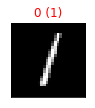

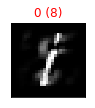

In [32]:
digits = tuple(range(10))
show_digits(x0, dnn.predict(x0), y0, digits)
show_digits(eva_adv_ds.X, dnn.predict(eva_adv_ds.X), eva_adv_ds.Y, digits)

In [33]:
pgd_ls_attack.f_seq

CArray(12,)(dense: [ 19.329091  13.296922   4.945312  -4.529959 -10.98631  -14.525495 -17.093864 -20.190557 -22.612732 -25.548998 -27.545806 -27.545806])

Plotting attack loss function:

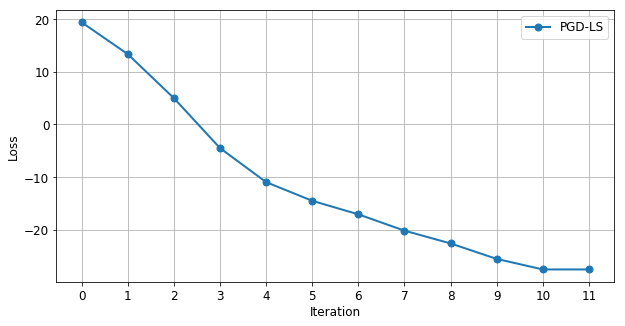

In [34]:
from secml.figure import CFigure
fig = CFigure(height=5, width=10)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot(pgd_ls_attack._f_seq, marker='o', label='PGD-LS')
fig.sp.grid()
fig.sp.xticks(range(pgd_ls_attack._f_seq.shape[0]))
fig.sp.xlabel('Iteration')
fig.sp.ylabel('Loss')
fig.sp.legend()

Plotting classifier confidence during attack:

In [35]:
pgd_ls_attack.x_seq

CArray(12, 784)(dense: [[0.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00  0.000000e+00] [0.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00  0.000000e+00] [0.000000e+00 0.000000e+00 0.000000e+00 ... 2.585483e-05 1.420379e-05  3.196059e-06] ... [0.000000e+00 0.000000e+00 0.000000e+00 ... 1.156611e-07 2.744839e-06  6.841699e-07] [0.000000e+00 0.000000e+00 0.000000e+00 ... 1.156611e-07 6.653579e-07  7.344744e-08] [0.000000e+00 0.000000e+00 0.000000e+00 ... 1.156611e-07 6.653579e-07  7.344744e-08]])

In [36]:
one_score, eight_score = [], []

for i in range(pgd_ls_attack.x_seq.shape[0]):
    s = dnn.decision_function(pgd_ls_attack.x_seq[i,:])
    one_score.append(s[1].item())
    eight_score.append(s[8].item())

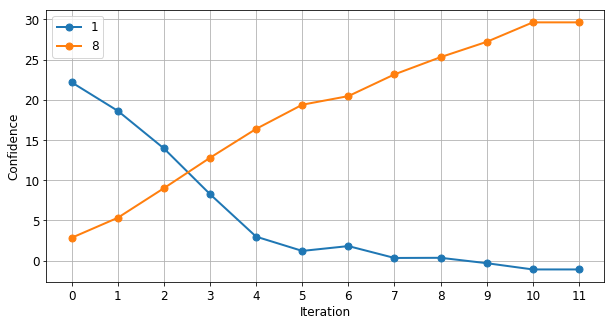

In [37]:
from secml.figure import CFigure
fig = CFigure(height=5, width=10)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot(one_score, marker='o', label='1')
fig.sp.plot(eight_score, marker='o', label='8')
fig.sp.grid()
fig.sp.xticks(range(pgd_ls_attack.x_seq.shape[0]))
fig.sp.xlabel('Iteration')
fig.sp.ylabel('Confidence')
fig.sp.legend()

---

# Security evaluation of a classifier

In [38]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:100, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=dnn,
                                    surrogate_classifier=dnn,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

In [39]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0, step=0.5, stop=5.1)

from secml.adv.seceval import CSecEval
dnn_seval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
dnn_seval.run_sec_eval(attack_ds, double_init=False)

Running security evaluation...


In [40]:
# Only required for visualization in notebooks
%matplotlib inline

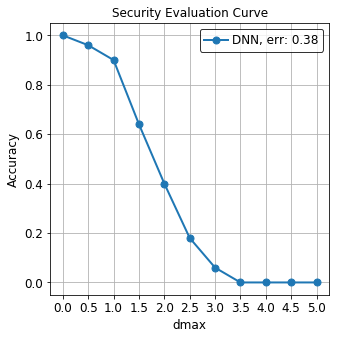

In [41]:
from secml.figure import CFigure
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    dnn_seval.sec_eval_data, marker='o', label='DNN', show_average=True)

---

# Build detector

In [42]:
from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.features import CNormalizerDNN, CNormalizerMinMax
from secml.ml.kernels import CKernelRBF

from components.c_classifier_kde import CClassifierKDE
from components.c_reducer_ptsne import CReducerPTSNE

In [43]:
dnn_feats = CNormalizerDNN(dnn)


feat_extr = CReducerPTSNE(n_components=2,
                          n_hiddens=[64, 64],
                          epochs=500,
                          batch_size=128,
                          preprocess=dnn_feats,
                          random_state=random_state)

nmz = CNormalizerMinMax(preprocess=feat_extr)

# clf = CClassifierMulticlassOVA(classifier=CClassifierKDE,
#                                kernel=CKernelRBF(gamma=10))

In [44]:
from secml.ml.classifiers import CClassifierSVM

clf = CClassifierMulticlassOVA(classifier=CClassifierSVM, kernel=CKernelRBF(gamma=10))

In [45]:
from secml.ml.classifiers.reject import CClassifierRejectThreshold

clf_rej = CClassifierRejectThreshold(clf, 0., preprocess=nmz)
clf_rej.threshold

0.0

In [ ]:
# Parameters for the Cross-Validation procedure
xval_params = {'C': [1e-3, 1e-2, 1e-1, 1, 100, 1000],
               'kernel.gamma': [0.01, 0.1, 1, 10, 100, 1e3]}

# Let's create a 3-Fold data splitter
from secml.data.splitter import CDataSplitterKFold
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# Select and set the best training parameters for the classifier
clf.verbose = 1

print("Estimating the best training parameters...")
best_params = clf.estimate_parameters(
    dataset=vl,
    parameters=xval_params,
    splitter=xval_splitter,
    metric='accuracy',
    perf_evaluator='xval'
)

print("The best training parameters are: ",
      [(k, best_params[k]) for k in sorted(best_params)])

Estimating the best training parameters...
2020-05-20 11:58:43,582 - CPerfEvaluatorXVal.0x7f0cdc049c18 - INFO - Parameters to evaluate: {'C': [0.001, 0.01, 0.1, 1, 100, 1000], 'kernel.gamma': [0.01, 0.1, 1, 10, 100, 1000.0]}
2020-05-20 11:58:43,662 - CClassifierMulticlassOVA.0x7f0cdc0ecc18 - INFO - Training against class: 0
2020-05-20 11:58:44,543 - CClassifierSVM.0x7f0cdc0ae518 - INFO - Training SVM with parameters: {'preprocess': None, 'n_jobs': 1, 'C': 0.001, 'class_weight': None, 'grad_sampling': 1.0, 'store_dual_vars': None, 'kernel': CKernelRBF{'gamma': 0.01, 'rv': None, 'preprocess': None, 'n_jobs': 1}}
2020-05-20 11:58:59,083 - CClassifierMulticlassOVA.0x7f0cdc0ecc18 - INFO - Training against class: 1
2020-05-20 11:58:59,965 - CClassifierSVM.0x7f0cdc049828 - INFO - Training SVM with parameters: {'preprocess': None, 'n_jobs': 1, 'C': 0.001, 'class_weight': None, 'grad_sampling': 1.0, 'store_dual_vars': None, 'kernel': CKernelRBF{'gamma': 0.01, 'rv': None, 'preprocess': None, 'n_

In [ ]:
# We can now fit the classifier
clf_rej.fit(vl.X, vl.Y)

In [ ]:
# END DEBUG
feat_extr.verbose = 0
feat_extr._mlp.verbose=0

Set the `threshold` to have around 10% of false positives

In [ ]:
clf_rej.threshold = 0.9

In [ ]:
# Compute predictions on a test set
y_pred = clf_rej.predict(vl.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=vl.Y, y_pred=y_pred)

print("Accuracy on training set: {:.2%}".format(acc))

In [ ]:
fpr = (y_pred < 0).sum() / y_pred.shape[0]
fpr

In [ ]:
# Compute predictions on a test set
y_pred = clf_rej.predict(ts.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

# Test it against BB adversarial samples

In [ ]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:100, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf_rej,
                                    surrogate_classifier=dnn,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

In [ ]:
print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    attack_ds.X, attack_ds.Y, double_init=True)
print("Attack complete!")

In [ ]:
from secml.array import CArray
from secml.ml.peval.metrics import CMetric, CMetricAccuracy


class CMetricAccuracyReject(CMetric):
    """Performance evaluation metric: Accuracy.

    Accuracy score is the percentage (inside 0/1 range)
    of correctly predicted labels. Rejected samples are
    considered as a correct prediction.

    The metric uses:
     - y_true (true ground labels)
     - y_pred (predicted labels)

    Attributes
    ----------
    class_type : 'accuracy-rej'

    """
    __class_type = 'accuracy-rej'
    best_value = 1.0

    def _performance_score(self, y_true, y_pred):
        """Computes the Accuracy score.

        Parameters
        ----------
        y_true : CArray
            Ground truth (true) labels or target scores.
        y_pred : CArray
            Predicted labels, as returned by a CClassifier.

        Returns
        -------
        metric : float
            Returns metric value as float.

        """
        acc_metric = CMetricAccuracy()

        # rejected samples are considered as correct predictions
        is_rej = y_pred == -1
        y_true_mod = y_true.deepcopy()
        y_true_mod[is_rej] = -1

        # check the classifier accuracy
        acc = acc_metric.performance_score(y_true=y_true_mod, y_pred=y_pred)

        return acc

In [ ]:
# metric = CMetricAccuracy()
metric = CMetricAccuracyReject()

In [ ]:
# Compute predictions on a test set
y_pred = clf_rej.predict(eva_adv_ds.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=eva_adv_ds.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

# Security Evaluation

In [ ]:
attack_ds

In [ ]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0.5, step=0.5, stop=5.1)

from secml.adv.seceval import CSecEval
tranfer_seval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
tranfer_seval.verbose = 1
tranfer_seval.run_sec_eval(attack_ds, double_init=False)

Compute reject percentage

In [ ]:
rej_percentage = lambda seval: [(p == -1).sum()/p.shape[0] for p in seval.sec_eval_data.Y_pred]
rej_percentage(tranfer_seval)

In [ ]:
%matplotlib inline

In [ ]:
from secml.figure import CFigure
fig = CFigure(height=8, width=10)

sp1 = fig.subplot(2,1,1)
# Convenience function for plotting the Security Evaluation Curve
sp1.plot_sec_eval(
    tranfer_seval.sec_eval_data, metric=CMetricAccuracyReject(),  marker='o', label='clf_rej', show_average=True)
# Plot rejects
sp2 = fig.subplot(2, 1, 2)
sp2.plot(e_vals, y=rej_percentage(tranfer_seval), marker='o', label='clf_rej')
sp2.xticks(e_vals)
sp2.xlabel("dmax")
sp2.ylabel("% Reject")
sp2.legend()
sp2.grid()

-------

# White-box evaluation

In [ ]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:100, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf_rej,
                                    surrogate_classifier=clf_rej,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

In [ ]:
print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    attack_ds.X, attack_ds.Y, double_init=True)
print("Attack complete!")

In [ ]:
# Compute predictions on a test set
y_pred = clf_rej.predict(eva_adv_ds.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=eva_adv_ds.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

# Security Evaluation

In [ ]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0.5, step=0.5, stop=5.1)

from secml.adv.seceval import CSecEval
whitebox_seval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
whitebox_seval.verbose = 1
whitebox_seval.run_sec_eval(attack_ds, double_init=False)

In [ ]:
%matplotlib inline

In [ ]:
from secml.figure import CFigure
fig = CFigure(height=8, width=10)

sp1 = fig.subplot(2,1,1)
# Convenience function for plotting the Security Evaluation Curve
sp1.plot_sec_eval(
    whitebox_seval.sec_eval_data, metric=CMetricAccuracyReject(),  marker='o', label='clf_rej', show_average=True)
# Plot rejects
sp2 = fig.subplot(2, 1, 2)
sp2.plot(e_vals, y=rej_percentage(whitebox_seval), marker='o', label='clf_rej')
sp2.xticks(e_vals)
sp2.xlabel("dmax")
sp2.ylabel("% Reject")
sp2.legend()
sp2.grid()

## +++++++++++++
# YOU ARE HERE!
## +++++++++++++

----

# Test against multiple attacks

Using `cleverhans` wrapper for multiple-attacks implementation

In [ ]:
from cleverhans.attacks import CarliniWagnerL2, ProjectedGradientDescent, \
    MomentumIterativeMethod,FastGradientMethod

In [ ]:
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

In [ ]:
e_vals = CArray.arange(start=0., step=0.5, stop=5.1)

In [ ]:
from collections import namedtuple
Attack = namedtuple('Attack', 'attack_cls short_name attack_params')

attacks = [
    Attack(FastGradientMethod, 'FGM', {'eps': dmax,
                                       'clip_max': ub,
                                       'clip_min': lb,
                                       'ord': 2}),
    Attack(ProjectedGradientDescent, 'PGD', {'eps': dmax,
                                             'eps_iter': 0.05,
                                             'nb_iter': 100,
                                             'clip_max': ub,
                                             'clip_min': lb,
                                             'ord': 2,
                                             'rand_init': False}),
    Attack(MomentumIterativeMethod, 'MIM', {'eps': dmax,
                                            'eps_iter': 0.05,
                                            'nb_iter': 100,
                                            'clip_max': ub,
                                            'clip_min': lb,
                                            'ord': 2,
                                            'decay_factor': 1}),
#     Attack(CarliniWagnerL2, 'CW2', {'binary_search_steps': 1,
#                                     'initial_const': 0.2,
#                                     'confidence': 10,
#                                     'abort_early': True,
#                                     'clip_min': lb,
#                                     'clip_max': ub,
#                                     'max_iterations': 50,
#                                     'learning_rate': 0.1})
]

Running attacks and compute evaluation curves

In [ ]:
attack_ds = ts[:100, :]
attack_ds

In [ ]:
sec_eval_bkp = []

In [ ]:
from secml.adv.attacks import CAttackEvasionCleverhans
from secml.adv.seceval import CSecEval
from secml.figure import CFigure
%matplotlib inline

fig = CFigure(5, 10)
for i, attack in enumerate(attacks):
    
    # Instantiate `cleverhans_attack`
    cleverhans_attack = CAttackEvasionCleverhans(
            classifier=dnn,
            surrogate_classifier=dnn,
            surrogate_data=tr,
            y_target=y_target,
            clvh_attack_class=attack.attack_cls,
            **attack.attack_params)
    
    # Run sec_eval
    sec_eval = CSecEval(attack=cleverhans_attack, param_name='attack_params.eps', param_values=e_vals)
    # Run the security evaluation using the test set
    print("Running security evaluation for {} attack".format(attack.short_name))
    sec_eval.run_sec_eval(attack_ds)
    
    # Save a backup
    sec_eval_bkp.append(sec_eval)
    
    # Plot
    fig.sp.plot_sec_eval(sec_eval.sec_eval_data, marker='o', label=attack.short_name, show_average=True)

fig.show()